## Polarization Angle Prediction Pipeline — Development Phases

This pipeline is being built **inside-out**, starting from idealized geometry and working outward toward real sensor data.

### Phase 1 — Geometry & Frame Transformations (current)
**Goal:** Define how a polarization vector is transported through space and turned into a predicted polarization angle.

Assume:
- Known line-of-sight (LOS)
- Known payload attitude
- Known constant vectors (e.g. polarization emission direction)

Focus on:
- Reference frames (payload → world/ENU)
- Vector rotations
- Projection perpendicular to LOS
- Construction of the sky-plane basis
- Extraction of a polarization angle

No real sensor data or hardware noise is involved in this phase.

---

### Phase 2 — Sensor Parsing → Geometry Inputs
**Goal:** Turn raw measurements into the geometric inputs required by Phase 1.

Implement:
- GPS → position → LOS vector (ENU)
- IMU + star camera → payload attitude → rotation matrix or quaternion

The geometry code from Phase 1 is not modified — only the inputs change.

---

### Phase 3 — Lab Measurement of Constants
**Goal:** Measure and fix time-independent quantities.

Includes:
- Polarization emission direction in the payload frame (`p_body`)
- Fixed rotations between payload, IMU, and star camera frames
- Polarimeter reference axis / angle zero-point

These values are inserted into the constants used by the existing pipeline.

---

### Phase 4 — Flight Data & Validation
**Goal:** Apply the full pipeline to real flight data.

Steps:
- Ingest real telemetry
- Compute predicted polarization angles
- Compare to polarimeter measurements
- Analyze residuals, offsets, and systematics

At this stage, discrepancies indicate physical or instrumental effects, not pipeline geometry errors.


# Drone-Based Absolute Polarization Calibration — One-Cell Summary

## Goal
Use a drone-mounted polarized source as an external reference to measure a **global instrumental polarization rotation** of a polarimeter (sky-referenced).

## Lab Calibration (internal parameters only)
In the lab, scan the HWP and fit detector signal vs HWP angle:
d(θ) ≈ A cos(4θ + φ_fit) + C  
For each lab geometry (different drone positions/orientations), extract **one scalar**: the fitted phase φ_fit.

**Known:** drone position & orientation, DRONE→instrument geometry, LOS, HWP angle vs time.  
**Unknown:** p_drone (source polarization direction in the DRONE frame, 2 DOF) and φ_HWP (HWP phase zero, a fixed hardware constant).

Forward model for configuration i:
φ_fit(i) = φ_HWP + 2·ψ_in(i)(p_drone)

Here ψ_in(i) is **not known beforehand**; it is a model prediction computed from a *trial* p_drone and the known geometry for configuration i.  
By fitting φ_fit across multiple non-degenerate geometries, p_drone and φ_HWP are solved **simultaneously**. This step uses no sky/ENU reference and therefore cannot remove any sky-referenced rotation.

## Flight / Absolute Calibration
With p_drone and φ_HWP fixed, fly the drone and compute the predicted sky-plane polarization angle α_pred from geometry. Measure α_meas from the polarimeter. A constant residual
Δα = wrap_180(α_meas − α_pred)
is the **global instrumental polarization rotation**; geometry-dependent residuals indicate more complex systematics.

## Key Conclusions
- HWP start position does **not** create a random offset if HWP phase is fitted.
- φ_HWP is a stable hardware constant (changes only with mechanical changes).
- Fitting p_drone and φ_HWP in the lab does **not** model out global sky-referenced rotation.
- The drone provides a true absolute polarization angle check against the sky.


# Phase 3 Strategy — Getting `p_body` and `phi_HWP_deg` (MVP, with honest error bars)

This project only works as an **absolute** calibration test if we avoid defining the drone polarization axis *using the polarimeter we are trying to calibrate*.

The safe separation is:

- **`p_body`** (source-side): measured from the **payload geometry / metrology**, *independent of the polarimeter*  
- **`phi_HWP_deg`** (instrument-side): measured from **HWP scans**, using the externally-defined `p_body` + geometry to predict `psi_in`

We accept that these can be **coarse** (few-degree uncertainties) for an MVP, as long as we quantify them.

---

## A. Measuring `p_body` (source polarization axis in payload frame)

### Definition
`p_body` is the linear polarization axis of the emitted beam expressed in the payload ("body") frame.
It is a **constant** vector attached to the payload hardware.

### MVP method (mechanical metrology)
1. Define a payload reference frame with clear physical fiducials:
   - pick a flat edge / scribed line on the payload plate as +x_body
   - pick a perpendicular edge as +y_body
   - define +z_body along the nominal beam propagation direction

2. Use the beamsplitter / wire-grid cube markings and/or visible mechanical features to define the emission polarization axis on the cube.
   - do **not** assume "perfectly aligned to cube edges" without checking; treat alignment as uncertain

3. Measure the cube’s polarization axis direction relative to the payload fiducials:
   - protractor / ruler / digital angle gauge is fine
   - record the measured angle(s) and convert into a unit vector `p_body`

4. Repeatability + uncertainty:
   - repeat the measurement **N times** (including remove/re-mount if possible)
   - adopt the **scatter** as `sigma_p_body_deg` (few degrees is acceptable for MVP)

### Optional sanity check (cheap optical analyzer)
Rotate a simple analyzer polarizer in front of the beam and confirm the max/min transmission directions match the mechanical axis.
This is *not* using the polarimeter, so it does not self-calibrate.

**Output of Part A:**  
`p_body` and an uncertainty (e.g. `sigma_p_body_deg`)

---

## B. Measuring `phi_HWP_deg` (polarimeter phase zero / HWP offset)

### What `phi_HWP_deg` is
We fit each HWP scan as:
\[
d(\theta) = A\cos(4\theta + \phi_{\rm fit}) + C
\]
`phi_HWP_deg` is the stable hardware constant phase offset that maps the incoming polarization angle to the fitted phase:
\[
\phi_{\rm fit} = \phi_{\rm HWP} + 2\psi_{\rm in}
\]
where `psi_in` is the predicted sky-plane (LOS-plane) polarization angle of the incoming light.

### Critical point: when does `phi_HWP_deg` absorb the effect we care about?
- If `psi_in` is *defined using the polarimeter’s own assumed reference axis*, then calibrating `phi_HWP_deg` can absorb the global rotation we want to measure.
- To avoid that, we must compute `psi_in` from **external geometry + measured `p_body`**, not from polarimeter outputs.

### MVP calibration procedure (lab)
1. Place payload in a fixed lab geometry and measure the required geometry inputs:
   - drone position / LOS vector
   - payload attitude (even if approximate)
   - use measured `p_body` from Part A

2. Compute `psi_in` with the forward model (vector transport + sky-plane projection).

3. Run **many HWP scans** without changing the setup:
   - fit each scan → `phi_fit_meas_deg[j]`

4. Compute a per-scan estimate:
\[
\phi_{\rm HWP}^{(j)} = \mathrm{wrap}_{360}\left(\phi_{\rm fit}^{(j)} - 2\psi_{\rm in}\right)
\]

5. Combine estimates on the circle (because phases wrap):
   - circular mean → `phi_HWP_deg`
   - circular scatter → `sigma_phi_HWP_deg`

### Robustness check (strongly recommended)
Repeat the above for a second configuration where the emitted polarization is rotated by ~90° (mechanically on the payload).

Expect:
\[
\phi_{\rm fit,2}-\phi_{\rm fit,1} \approx 2(\psi_{\rm in,2}-\psi_{\rm in,1}) \approx 180^\circ \ (\mathrm{mod}\ 360)
\]

If this fails, it usually indicates:
- wrong sign/axis convention
- wrong modulo handling (90 vs 180 vs 360)
- incorrect mapping between cube markings and `p_body`
- a geometry bug

**Output of Part B:**  
`phi_HWP_deg` and an uncertainty (e.g. `sigma_phi_HWP_deg`)

---

## Summary (what we lock in before flight)
Before flight analysis, we fix:
- `p_body` ± `sigma_p_body_deg` from payload metrology (independent of the polarimeter)
- `phi_HWP_deg` ± `sigma_phi_HWP_deg` from repeated HWP scans using externally predicted `psi_in`

Then in flight we treat both as constants and measure a residual:
\[
\Delta\alpha = \mathrm{wrap}_{180}(\alpha_{\rm meas} - \alpha_{\rm pred})
\]
A constant `Δα` across flight geometries is the global instrumental rotation; geometry-dependent residuals indicate additional systematics.


## Core Conclusions: What Matters and Why

### What is actually being measured
The goal of the drone-based calibration system is **not** to predict the exact numerical angle that the polarimeter should read, nor to fully model the polarimeter’s internal geometry. In a real experiment, the quantity of interest is:

> **How well the instrument can measure the linear polarization angle of incoming light.**

Absolute polarization calibration is therefore about constraining a **constant rotation** between an external reference frame and the instrument’s measurement frame.

---

### Role of the drone payload
The drone payload acts as an **external polarized reference source**. Using laboratory measurements of the payload and a geometric reconstruction pipeline based on drone position and attitude, the polarization angle of the emitted light can be predicted in a well-defined external frame (e.g., ENU or sky).

This predicted angle does **not** need to match the polarimeter’s internal angle convention.

---

### What the polarimeter contributes
The ground-based polarimeter measures the incoming polarization angle in its own instrument frame. This measurement includes an unknown but constant offset that absorbs:
- the half-wave plate encoder zero,
- optical alignment offsets,
- internal sign and angle conventions.

This offset is not a problem; it is the **calibration target**.

---

### Predicted vs. measured angle comparison
The correct comparison is:
- **x-axis:** predicted polarization angle from the drone pipeline
- **y-axis:** measured polarization angle from the polarimeter

These quantities are expected to follow a linear relationship with:
- **unit slope**, and
- a **constant intercept**.

The intercept represents the total rotation between the external reference frame and the instrument frame.

---

### Within-run precision
Within a single run, many measurements spanning a range of predicted polarization angles can be collected (e.g., by rotating the drone in yaw while maintaining beam pointing).

Fitting the predicted vs. measured angles yields:
- a run-level intercept, and
- an uncertainty on that intercept.

This uncertainty represents the **within-run statistical precision** and reflects:
- polarimeter measurement noise,
- HWP fitting uncertainty,
- drone attitude reconstruction uncertainty,
- payload polarization characterization uncertainty.

---

### Run-to-run repeatability
Repeating the experiment across multiple runs produces a distribution of intercept values.

The scatter of these intercepts quantifies the **run-to-run repeatability**, capturing:
- re-homing and remounting effects,
- thermal and mechanical drift,
- software and operational variability.

This repeatability is typically the most honest measure of the achievable calibration precision.

---

### Experimental implication for payload orientation
To enable clean sampling of many polarization angles without losing the source:
- the payload emission axis should be oriented close to **nadir**,
- rotating the drone in yaw should rotate polarization without changing beam pointing.

This avoids the need for gimbals or complex flight trajectories and keeps the source within the polarimeter field of view.

---

### Final reported result
The appropriate final claim is of the form:

> *The drone-based system enables calibration of the absolute linear polarization angle of a polarimeter to X degrees.*

Here:
- **X** is supported by the run-to-run repeatability,
- within-run uncertainties are quoted to demonstrate statistical capability.

This framing matches how real polarization-sensitive experiments evaluate and report calibration performance.


## Two-Stage Interpretation of the Drone Polarization Calibration Method

### Stage 1: Relative Polarization Calibration (Method Validation)

The goal of Stage 1 is to validate the calibration method by demonstrating precise and repeatable **relative** polarization angle reconstruction. In this stage, the absolute emitted polarization angle of the drone payload does **not** need to be known.

Let:

- $\psi_{\mathrm{meas}}(t)$ be the polarization angle measured by the polarimeter (instrument frame),
- $\psi_{\mathrm{pred}}(t)$ be the polarization angle predicted from drone geometry,
- $\delta_{\mathrm{inst}}$ be a constant instrument offset (HWP zero, optics, conventions),
- $\delta_{\mathrm{payload}}$ be an unknown constant payload polarization offset.

The true emitted polarization angle is:

$$
\psi_{\mathrm{true}}(t) = \psi_{\mathrm{pred}}(t) + \delta_{\mathrm{payload}}
$$

The measured angle is:

$$
\psi_{\mathrm{meas}}(t) = \psi_{\mathrm{true}}(t) + \delta_{\mathrm{inst}}
$$

Combining these expressions gives:

$$
\psi_{\mathrm{meas}}(t) = \psi_{\mathrm{pred}}(t) + \left( \delta_{\mathrm{payload}} + \delta_{\mathrm{inst}} \right)
$$

Only the **sum** of the payload and instrument offsets is observable.

To remove the unidentifiable absolute offset, define the reference:

$$
\psi_{\mathrm{pred}}(t_0) \equiv 0
$$

and work with relative angles:

$$
\Delta \psi_{\mathrm{pred}}(t) = \psi_{\mathrm{pred}}(t) - \psi_{\mathrm{pred}}(t_0)
$$

The measurement model then becomes:

$$
\psi_{\mathrm{meas}}(t) = \Delta \psi_{\mathrm{pred}}(t) + b_{\mathrm{run}}
$$

where the run-level intercept is:

$$
b_{\mathrm{run}} = \delta_{\mathrm{payload}} + \delta_{\mathrm{inst}}
$$

Fitting $\psi_{\mathrm{meas}}$ versus $\Delta \psi_{\mathrm{pred}}$ yields a unit slope, a run-level intercept $b_{\mathrm{run}}$, and an uncertainty $\sigma(b_{\mathrm{run}})$ that quantifies within-run precision. Scatter in $b_{\mathrm{run}}$ across runs measures run-to-run repeatability.

---

### Stage 2: Absolute Polarization Calibration (Deployment)

To deploy the system as a true telescope calibrator, the payload polarization must be tied to an external reference frame via an independent laboratory measurement:

$$
\delta_{\mathrm{payload}} \pm \sigma_{\mathrm{payload}}
$$

The absolute predicted polarization angle is then:

$$
\psi_{\mathrm{pred}}^{\mathrm{abs}}(t) = \psi_{\mathrm{pred}}(t) + \delta_{\mathrm{payload}}
$$

The instrument polarization offset becomes:

$$
\delta_{\mathrm{inst}} = b_{\mathrm{run}} - \delta_{\mathrm{payload}}
$$

The total calibration uncertainty is:

$$
\sigma^2(\delta_{\mathrm{inst}}) =
\sigma^2(b_{\mathrm{run}}) + \sigma^2(\delta_{\mathrm{payload}})
$$

---

### Summary

- Relative polarization control is sufficient to validate the calibration method.
- Absolute payload metrology is required only to tie the calibration to a physical reference frame.
- Stage 1 establishes precision and repeatability; Stage 2 enables operational telescope calibration.


## Next Steps: Parallel Hardware + Pipeline Work

### Track 1: Payload / Lab Work (Geometry + Stage-2 Metrology)

**Goals**
- Reconfigure payload to point **straight down (nadir)**.
- Establish a stable payload/body reference frame.
- Begin measurements needed to define a true $a_{\mathrm{pred}}$ (Stage 2).

**Tasks**
- Redesign mounting so beam axis satisfies  
  $$\hat{k}_b \approx (0, 0, -1)$$
  in the payload/body frame.
- Add clear physical fiducials defining $+\hat{x}_b$, $+\hat{y}_b$, and $+\hat{z}_b$.
- Measure the emitted polarization orientation in the payload frame:
  - either as a unit vector $\hat{p}_b$,
  - or as a constant offset $\delta_{\mathrm{payload}}$ relative to a fiducial.
- Quantify uncertainty on $\hat{p}_b$ or $\delta_{\mathrm{payload}}$.
- Verify stability of the polarization orientation under re-mounting.

**Deliverables**
- Defined payload frame $(\hat{x}_b, \hat{y}_b, \hat{z}_b)$.
- Source model: $\hat{k}_b$, $\hat{p}_b$ (or $\delta_{\mathrm{payload}}$) with uncertainty.
- Documentation sufficient to apply absolute anchoring later without re-flying.

---

### Track 2: Angle Prediction Pipeline (End-to-End, Simulated)

**Goals**
- Build a complete, end-to-end pipeline independent of flight hardware.
- Validate Stage-1 (relative) calibration logic with simulated data.
- Prepare for direct ingestion of real IMU, GPS, and polarimeter data.

**Tasks**
- Define expected input formats for:
  - payload IMU attitude (quaternions or Euler angles with timestamps),
  - GPS position (ENU or lat/lon/alt with timestamps),
  - polarimeter measurements $a_{\mathrm{meas}}(t)$ with uncertainties.
- Implement geometry $\rightarrow$ predicted polarization angle:
  - support both $\psi_{\mathrm{pred}}(t)$ and $\Delta\psi_{\mathrm{pred}}(t)$.
- Generate simulated “flight” data streams to exercise the full pipeline.
- Fit $a_{\mathrm{meas}}$ versus $\psi_{\mathrm{pred}}$ (or $\Delta\psi_{\mathrm{pred}}$):
  - extract slope, intercept $b_{\mathrm{run}}$, and uncertainties.
- Handle polarization angle wrapping (180° periodicity).
- Allow optional inclusion of $\delta_{\mathrm{payload}}$ (Stage-2 toggle).

**Deliverables**
- End-to-end runnable pipeline using simulated inputs.
- Final plots: predicted vs. measured angle with fit and intercept.
- Run-level summary outputs ready to stack across multiple runs.

---

### Interface Between Tracks

- Shared definition of the payload/body frame.
- Consistent polarization source model ($\hat{p}_b$ or $\delta_{\mathrm{payload}}$).
- Agreed timestamp convention across IMU, GPS, and polarimeter data.

These two tracks can proceed independently and be combined once both are mature.


In [1]:
# we can keep functions in the py file rather than here in the notebook
import function
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
function.imports()

Successfully imported functions.


#### We need to somehow get the emission polarization angle based on the IMU, GPS, and star camera data input streams. 

In [7]:
E = np.array([1.0, 0.0, 0.0])
N = np.array([0.0, 1.0, 0.0])
U = np.array([0.0, 0.0, 1.0])

In [6]:
function.unit

<function function.unit(v: numpy.ndarray) -> numpy.ndarray>

In [8]:
def project_perp(v_world, los_world):
    """Project v_world into the plane perpendicular to los_world."""
    los_hat = function.unit(los_world)
    return v_world - np.dot(v_world, los_hat) * los_hat

## Toy 45-45 Angles by Construction

In [42]:
# line of sight of the drone in ENU, towards the sky
los_ENU = function.unit([0.0, 1.0, 1.0])

# propagation vector from the drone source, in DRONE frame
k_drone = function.unit(np.array([1.0, 0.0, -1.0]))

# polarization axis in the DRONE frame ⟂ k_drone
p_drone = function.unit(np.array([1.0, 0.0, 1.0]))

# assumed rotation matrix that transforms DRONE to ENU (from attitude, no rotation for now)
R_ENU_from_drone = np.eye(3)

# polarization axis in ENU frame
p_ENU = R_ENU_from_drone @ p_drone

# normalized component of polarization oscillation perpandicular to LOS, ENU frame
p_ENU_perpnorm = function.unit(project_perp(p_ENU, los_ENU))

# we define the SKY plane 2D basis, which is what the polarimeter inherently measures in
E_sky_perpnorm = function.unit(project_perp(E, los_ENU))
N_sky_perpnorm = function.unit(np.cross(los_ENU, E_sky_perpnorm))

# find the x and y components of the polarization angle vector in the SKY plane
xcomp = np.dot(p_ENU_perpnorm, E_sky_perpnorm)
ycomp = np.dot(p_ENU_perpnorm, N_sky_perpnorm)

# covert the x and y components to an angle, in SKY plane which matches measurement plane
alpha_pred_rad = np.arctan2(ycomp, xcomp)
alpha_pred_deg = np.degrees(alpha_pred_rad)

# wrap modulo 180 since this is the polarization angle
delta_HWP_deg = 0  # this term must be measured, constant offset caused by zeroed HWP, fit with p_drone. 
apred = (alpha_pred_deg + delta_HWP_deg) % 180.0

## Polarization Angle Projection from Data

In [51]:
# ==============================
# INPUTS THAT MUST COME FROM DATA
# ==============================

# line of sight of the drone in ENU (polarimeter -> drone); you can still use a toy vector here
los_ENU = function.unit([0.0, 1.0, 1.0])  # REQUIRES REAL NUMBERS FROM DRONE (FLIGHT DATA)

# assumed rotation matrix that transforms DRONE -> ENU (from attitude, no rotation for now)
R_ENU_from_drone = np.eye(3)  # REQUIRES REAL NUMBERS FROM DRONE (FLIGHT DATA)

# polarization axis in the DRONE frame (emitter axis). It does NOT have to be ⟂ k_drone for all geometries.
p_drone = function.unit(np.array([1.0, 0.0, 1.0]))  # REQUIRES REAL NUMBERS LATER (LAB FIT)

# constant HWP phase offset (system constant). This is the thing you solve for in the LAB FIT.
# IMPORTANT: this is the phase that appears inside cos(4*theta + phi_fit) when you fit the sinusoidal graph.
phi_HWP_deg = 0.0  # REQUIRES REAL NUMBERS LATER (LAB FIT)

# ==============================
# FIXED / DEFINED CONSTANTS
# ==============================

# define the SKY plane 2D basis reference direction in ENU (e.g. East); must be consistent with your convention
E = np.array([1.0, 0.0, 0.0])

# ==============================
# GEOMETRY: CONSISTENT PROPAGATION DIRECTION
# ==============================

# derive the propagation direction consistently from LOS + attitude
# propagation is drone -> polarimeter, so it's opposite of (polarimeter -> drone)
k_ENU = -los_ENU

# rotation ENU -> DRONE is the inverse (transpose) of DRONE -> ENU
R_drone_from_ENU = R_ENU_from_drone.T

# propagation vector of the ray that reaches the polarimeter, expressed in DRONE frame
k_drone = function.unit(R_drone_from_ENU @ k_ENU)

# enforce transversality for the ray that reaches the polarimeter: project p_drone ⟂ k_drone (per geometry)
p_eff_drone = function.unit(project_perp(p_drone, k_drone))

# polarization axis in ENU frame (for this ray)
p_ENU = R_ENU_from_drone @ p_eff_drone

# normalized component of polarization oscillation perpendicular to LOS, ENU frame
p_ENU_perpnorm = function.unit(project_perp(p_ENU, los_ENU))

# ==============================
# SKY-PLANE PROJECTION: PREDICT INCOMING POLARIZATION ANGLE
# ==============================

# we define the SKY plane 2D basis, which is what the polarimeter inherently measures in
E_sky_perpnorm = function.unit(project_perp(E, los_ENU))
N_sky_perpnorm = function.unit(np.cross(los_ENU, E_sky_perpnorm))

# find the x and y components of the polarization vector in the SKY plane
xcomp = np.dot(p_ENU_perpnorm, E_sky_perpnorm)
ycomp = np.dot(p_ENU_perpnorm, N_sky_perpnorm)

# convert the x and y components to an angle, in SKY plane which matches measurement plane
psi_in_rad = np.arctan2(ycomp, xcomp)
psi_in_deg = np.degrees(psi_in_rad)

# wrap modulo 180 since this is a polarization angle (psi == psi + 180)
psi_in_deg = psi_in_deg % 180.0

# ==============================
# PREDICT WHAT YOU READ OFF THE SINUSOIDAL HWP SCAN GRAPH
# ==============================
# If your polarimeter graph is fit as:
#   d(theta) = A * cos(4*theta + phi_fit) + C
# then the fitted phase obeys:
#   phi_fit = phi_HWP + 2*psi_in
#
# NOTE: phi_fit is naturally a phase modulo 360, but many pipelines report it modulo 90 because of 4*theta symmetry.
phi_fit_pred_deg = (phi_HWP_deg + 2.0 * psi_in_deg) % 360.0

psi_graph_pred_deg_mod90 = (phi_fit_pred_deg / 2.0) % 90.0


In [50]:
psi_graph_pred_deg_mod90

54.735610317245346

In [30]:
alpha_pred_deg % 180

144.73561031724535

In [37]:
tol = 1e-10
assert abs(np.linalg.norm(los_ENU) - 1) < tol
assert abs(np.linalg.norm(k_drone) - 1) < tol
assert abs(np.linalg.norm(p_drone) - 1) < tol
assert abs(np.linalg.norm(p_ENU_perpnorm) - 1) < tol
assert abs(np.linalg.norm(E_sky_perpnorm) - 1) < tol
assert abs(np.linalg.norm(N_sky_perpnorm) - 1) < tol
assert abs(np.dot(p_drone, k_drone)) < tol
assert abs(np.dot(p_ENU_perpnorm, los_ENU)) < tol
assert abs(np.dot(E_sky_perpnorm, los_ENU)) < tol
assert abs(np.dot(N_sky_perpnorm, los_ENU)) < tol
assert abs(np.dot(E_sky_perpnorm, N_sky_perpnorm)) < tol
assert abs((xcomp**2 + ycomp**2) - 1.0) < 1e-9
p_test = E_sky_perpnorm
x = np.dot(p_test, E_sky_perpnorm)
y = np.dot(p_test, N_sky_perpnorm)
a = np.degrees(np.arctan2(y, x)) % 180
assert abs(a - 0.0) < 1e-9
p_test = N_sky_perpnorm
x = np.dot(p_test, E_sky_perpnorm)
y = np.dot(p_test, N_sky_perpnorm)
a = np.degrees(np.arctan2(y, x)) % 180
assert abs(a - 90.0) < 1e-9
a1 = (np.degrees(np.arctan2(ycomp, xcomp)) % 180.0)
a2 = (np.degrees(np.arctan2(-ycomp, -xcomp)) % 180.0)
assert abs(a1 - a2) < 1e-9

In [ ]:
assert abs((xcomp**2 + ycomp**2) - 1.0) < 1e-9


(0.0, 180.0)

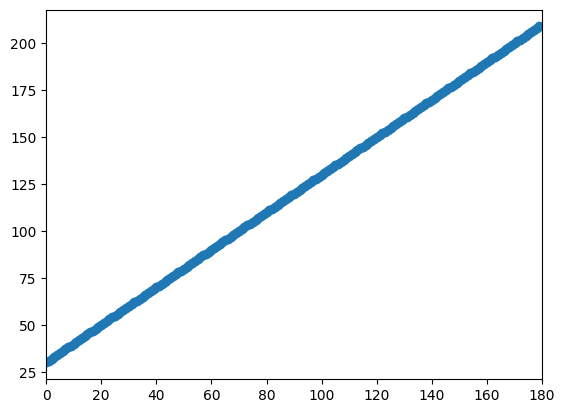

In [12]:
plt.scatter(np.arange(180), np.arange(180) + 30)
plt.xlim([0, 180])